<a href="https://colab.research.google.com/github/kiah-ucsd/DSE200/blob/MiniProject/Mini_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project DSE 200: Starbucks Customer Data Analysis

In [ ]:
%pip install numpy pandas matplotlib seaborn scipy scikit-learn kagglehub xgboost

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import ast
from scipy import stats
import itertools
from scipy.stats import spearmanr
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, classification_report, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


In [3]:
# Download latest version
path = kagglehub.dataset_download("ihormuliar/starbucks-customer-data")

print("Path to dataset files:", path)

# portfolio.csv , drop bad index, transform channels str into list object
portfolio_df = pd.read_csv(path + "/portfolio.csv")
portfolio_df.drop(columns=['Unnamed: 0'], inplace=True)

# profile.csv, id is the offer id and the type of offer it is
profile_df = pd.read_csv(path + "/profile.csv")
profile_df.drop(columns=['Unnamed: 0'], inplace=True)
profile_df.rename(columns = {'id':'person'}, inplace = True)

# transcript.csv. drop bad index, transform value str into list object
transcript_df = pd.read_csv(path + "/transcript.csv")
transcript_df.drop(columns=['Unnamed: 0'], inplace=True)
transcript_df['value'] = transcript_df.value.apply(ast.literal_eval)


Path to dataset files: C:\Users\jlu2\.cache\kagglehub\datasets\ihormuliar\starbucks-customer-data\versions\1


## Data cleaning, merging, and creating relevant columns

#### Inspect Portfolio, Profile, and Transcript shapes 
- gender is not uniformly distributed, so final data will likely be skewed when including that data

In [38]:
#transcript_df groupby person gives exact same shape as profile_df
print('profile_df shape ',profile_df.shape)
print('transcript_df shape ',transcript_df.shape)
print('portfolio_df shape ',portfolio_df.shape)
print('transcript_df.groupby("person"):',transcript_df.groupby('person').agg('count').shape)
print(profile_df.gender.value_counts())

profile_df shape  (17000, 5)
transcript_df shape  (306534, 4)
portfolio_df shape  (10, 10)
transcript_df.groupby("person"): (17000, 3)
gender
M    8484
F    6129
O     212
Name: count, dtype: int64


#### Split portfolio.channels into web, email, mobile, and social bool columns for easier access

In [5]:
#manually create because i don't want to deal with weird string names and list names are uneven
portfolio_df['web'] = False
portfolio_df.loc[portfolio_df.channels.str.contains('web'),'web'] = True
portfolio_df['email'] = False
portfolio_df.loc[portfolio_df.channels.str.contains('email'),'email'] = True
portfolio_df['mobile'] = False
portfolio_df.loc[portfolio_df.channels.str.contains('mobile'),'mobile'] = True
portfolio_df['social'] = False
portfolio_df.loc[portfolio_df.channels.str.contains('social'),'social'] = True


#### Group transcripts_df by events and split into 4 dataframes
- saving values as dict of dfs with transcript_df.event.unique() as key names for easier access...otherwise i have to multi-index access everything
- the dataframes are called with ['offer received', 'offer viewed', 'transaction', 'offer completed']

In [6]:
event_dict = {k:v for (k,v) in transcript_df.groupby('event')}
value_dict = {}

for key, dict_df in event_dict.items():
    value_dict[key] = dict_df.merge(pd.json_normalize(dict_df['value']),
                                                                     left_on=dict_df.index,
                                                                     right_on = dict_df['value'].index,
                                                                     how='left').drop(columns=['value']).set_index('key_0')

    if 'completed' in key:
        value_dict[key] = value_dict[key]\
            .merge(portfolio_df, left_on = 'offer_id', right_on ='id', how='left')\
            .drop(columns=['reward_y', 'channels','id'])\
            .rename(columns={'reward_x':'reward'})\

    elif 'received' in key:
        value_dict[key].rename(columns = {'offer id':'offer_id'}, inplace=True)
        value_dict[key] = value_dict[key].merge(portfolio_df, left_on = 'offer_id', right_on ='id', how='left')\
            .drop(columns=['channels', 'id'])\

    elif 'viewed' in key:
        value_dict[key].rename(columns = {'offer id':'offer_id'}, inplace=True)
        value_dict[key] = value_dict[key].merge(portfolio_df, left_on = 'offer_id', right_on ='id', how='left')\
            .drop(columns=['channels', 'id'])\
    #check if any na values
    if value_dict[key].isna().sum().any():
        print(f'there are nans in {key}')
    else:
        print(f'yay {key} is great')

yay offer completed is great
yay offer received is great
yay offer viewed is great
yay transaction is great


#### Group each transcript_df[event] by person and agg counts, means, and other relevant columns 
- add event column as indentifier for future ungrouping if necessary

In [7]:
#group by person on each dataframe of ['offer received', 'offer viewed', 'transaction', 'offer completed']
#count number of recurrent people, agg mean rewards and time
#slow (~takes 1min) because it is not vectorized solution

def analysis_df(column):
    col_list = []
    tag = ''
    for k,v in value_dict[column].groupby('person'):
        if 'transaction' in column:
            minidict = {'person':str(k),
                        f'numCount_{column}': v.shape[0],
                        f'mean_time_{column}':v.time.mean(),
                        f'std_time_{column}':v.time.std(),
                        f'mean_amount_{column}':v.amount.mean(),
                        f'sum_amount_{column}':v.amount.sum(),
                        f'std_amount_{column}':v.amount.std(),
                        f'event': v.event.unique()[0]
                        }
            col_list.append(minidict)

        else:
            if 'received' in column:
                tag = re.sub(r"offer received","OR", column)
            elif 'completed' in column:
                tag = re.sub(r"offer completed","OC", column)
            else:
                tag = re.sub(r"offer viewed","OV", column)
            minidict2 = v.offer_type.value_counts().to_dict()
            minidict = {'person':str(k),
                    f'numCount_{tag}': v.shape[0],
                    f'mean_time_{tag}':v.time.mean(),
                    f'std_time_{tag}':v.time.std(),
                    f'mean_reward_{tag}': v.reward.mean(),
                    f'sum_reward_{tag}': v.reward.sum(),
                    f'std_reward_{tag}':v.reward.std(),
                    f'event': v.event.unique()[0],
                    f'mean_difficulty_{tag}':v.difficulty.mean(),
                    f'mean_duration_{tag}':v.duration.mean(),
                    f'pct_web_{tag}':v.web.mean(), # percentage of all offers that come via web
                    f'pct_email_{tag}':v.email.mean(), # percentage of all offers that come via email
                    f'pct_mobile_{tag}':v.mobile.mean(), # percentage of all offers that come via mobile
                    f'pct_social_{tag}':v.social.mean(), # percentage of all offers that come via social
                    }
            col_list.append(minidict|minidict2)

    minidf = pd.DataFrame(col_list)
    minidf = minidf.rename(columns={'informational':f'numCount_informational_{tag}',
                           'discount':f'numCount_discount_{tag}',
                           'bogo': f'numCount_bogo_{tag}'})

    return minidf
    # return col_list

#these 3 should be one dataframe
offer_received_df = analysis_df('offer received')
offer_viewed_df = analysis_df('offer viewed')
offer_completed_df = analysis_df('offer completed')

#this should be its own df
transaction_df = analysis_df('transaction')


#### Check results of transcript_df['event'], when grouped by person
- there is a discrepancy between people buying things and people getting rewards
- the groupby on transcript_df but with filter on event gives similar lengths to original groupby on "person"
- there is a 3800 person difference between transactions and the number of times rewards are cashed in
- we should find differences between rows with event_OC == True /False with a classifier / linear regression

In [8]:
print(f'offers received: {offer_received_df.shape}\n',
      f'offers viewed: {offer_viewed_df .shape}\n',
      f'transations: {transaction_df.shape}\n',
      f'offer completed:{offer_completed_df.shape}\n',
     f'total people: {transcript_df.groupby('person').agg('count').shape[0]}')
print(transaction_df.shape[0] - offer_completed_df.shape[0])

offers received: (16994, 17)
 offers viewed: (16834, 17)
 transations: (16578, 8)
 offer completed:(12774, 16)
 total people: 17000
3804


#### Merge all transaction_df['event'] to create a master dataframe of all relevant data for modeling
- joining starting with offer_recieved dataframe since it has the largest shape
- - this will cause Nan's to appear in the final dataset, but these will be backfilled with .fillna(0) when necessary
- encode gender to male == 0, female ==1, and idk == 3 so that we can use gender as part of our correlation and model data
- backfill event columns due to the size mismatch

In [9]:

master_df = offer_received_df.merge(offer_viewed_df , left_on = 'person', right_on = 'person', how='left', suffixes=('_OR','_OV'))
master_df = master_df.merge(offer_completed_df, left_on = 'person', right_on = 'person', how='left', suffixes = (None,'_OC'))
master_df = master_df.merge(transaction_df, left_on = 'person', right_on = 'person', how='left', suffixes = (None,'_TR'))
master_df.rename(columns={'event':'event_OC'}, inplace=True)
master_df.loc[~(master_df.event_OR.isna()), 'event_OR'] = 1
master_df.loc[~(master_df.event_OV.isna()), 'event_OV'] = 1
master_df.loc[~(master_df.event_OC.isna()), 'event_OC'] = 1
master_df.loc[~(master_df.event_TR.isna()), 'event_TR'] = 1
master_df.loc[(master_df.event_OR.isna()), 'event_OR'] = 0
master_df.loc[(master_df.event_OV.isna()), 'event_OV'] = 0
master_df.loc[(master_df.event_OC.isna()), 'event_OC'] = 0
master_df.loc[(master_df.event_TR.isna()), 'event_TR'] = 0
master_df = master_df.merge(profile_df, left_on = 'person',right_on = 'person', how='left')
master_df.gender = master_df.apply(lambda x: 0 if x['gender'] == 'M' else (1 if x['gender'] == 'F' else 2), axis=1)

### Find relevant correlations for data exploration 
- find all the correlations between all numerical columns  (no identifier, string, or categorial)
 - plotting this would be a nightmare right now: most of which are probably useless
 - 'intra' column is created to filter pairs that are within the same "event" dataframe
 - takes like 1min to run since solution is not vectorized


In [11]:
corr_values = []
combo_list = list(itertools.combinations(master_df.drop(columns=['person','event_OC','event_OR','event_TR','event_OV']).columns, r=2))
combo_list
for _, i in enumerate(combo_list):
    r,p = spearmanr(master_df[i[0]], master_df[i[1]], nan_policy='omit')
    corr_values.append({'pair': i[0] + "_" + i[1],
                        'val1':i[0],
                        'val2':i[1],
                        'r':r,
                        'p':p})

corr_df = pd.DataFrame(corr_values)
corr_df['intra'] = corr_df.apply(lambda x: ((x.val1[-2:] in x.val2) or (x.val2[-2:] in x.val1)), axis=1) #cleanup corr_df...im sure theres a more elegant way to do this but idc
corr_df

C:\Users\jlu2\AppData\Local\Temp\ipykernel_33628\2223755931.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = spearmanr(master_df[i[0]], master_df[i[1]], nan_policy='omit')


,pair,val1,val2,r,p,intra
0,numCount_OR_mean_time_OR,numCount_OR,mean_time_OR,0.042085,4.057874e-08,True
1,numCount_OR_std_time_OR,numCount_OR,std_time_OR,-0.040243,1.635609e-07,True
2,numCount_OR_mean_reward_OR,numCount_OR,mean_reward_OR,0.001457,8.493280e-01,True
3,numCount_OR_sum_reward_OR,numCount_OR,sum_reward_OR,0.508219,0.000000e+00,True
4,numCount_OR_std_reward_OR,numCount_OR,std_reward_OR,0.053464,3.423495e-12,True
...,...,...,...,...,...,...
1426,gender_became_member_on,gender,became_member_on,-0.010896,1.554999e-01,True
1427,gender_income,gender,income,0.217623,2.302091e-158,False
1428,age_became_member_on,age,became_member_on,-0.019581,1.069237e-02,False
1429,age_income,age,income,0.298868,1.883439e-303,False


#### Create pos_corr and neg_corr dataframes to filter/sort corr_df to the strongest r-values
- plot all features within master_df and find the strongest features
- grade features based on its mean r-score and the number of times the feature appears in strongly correlated pairs
  - e.g, sum_reward_OR is strongly correlated (mean r-score between 0.4 and 0.5) to 13 other variables out of 59 total variables

In [14]:

corr_df2 = corr_df.loc[(corr_df.val1 != corr_df.val2)
    & (corr_df.r > 0.1)
    & (corr_df.p < 0.05)
    & (corr_df.intra == False)].sort_values(by='r',ascending=False)

pos_corr = corr_df2.melt(id_vars=['pair','r'], value_vars =['val1','val2'], value_name = 'field')\
    .groupby('field')['r'].describe()
pos_corr.reset_index(inplace=True)

pos_corr['event'] = pos_corr.field.apply(lambda x: 'offer completed' if 'OC' in x else
                                         ('offer received' if 'OR' in x else
                                          ('offer viewed' if 'OV' in x else 'class')))

pos_corr2 = pos_corr.copy()  #copy so that we can refer back to original master_df columns while cleaning up the matplotlib xlabels

pos_corr = pos_corr.sort_values(by=['event'], ascending=False)
pos_corr.loc[pos_corr.event.str.contains('offer'), 'field'] = pos_corr.field.str[:-3]
pos_corr.loc[pos_corr.field.str.contains('numCount_transaction'), 'field'] = 'numCount_purchases'
pos_corr.loc[pos_corr.field.str.contains('transaction'), 'field'] = pos_corr.field.str[:-12]

pos_corr['bin_mean_R'] = ''
pos_corr.loc[pos_corr['mean'].between(0.1,0.2), 'bin_mean_R'] = '0.1 - 0.2'
pos_corr.loc[pos_corr['mean'].between(0.2,0.3), 'bin_mean_R'] = '0.2 - 0.3'
pos_corr.loc[pos_corr['mean'].between(0.3,0.4), 'bin_mean_R'] = '0.3 - 0.4'
pos_corr.loc[pos_corr['mean'].between(0.4,0.5), 'bin_mean_R'] = '0.4 - 0.5'


In [15]:
corr_df2 = corr_df.loc[(corr_df.val1 != corr_df.val2)
    & (corr_df.r < -0.1)
    & (corr_df.p < 0.05)
    & (corr_df.intra == False)].sort_values(by='r',ascending=False)

neg_corr = corr_df2.melt(id_vars=['pair','r'], value_vars =['val1','val2'], value_name = 'field')\
    .groupby('field')['r'].describe()\
neg_corr.reset_index(inplace=True)

neg_corr['event'] = neg_corr.field.apply(lambda x: 'offer completed' if 'OC' in x else
                                         ('offer received' if 'OR' in x else
                                          ('offer viewed' if 'OV' in x else 'class')))

neg_corr2 = neg_corr.copy() #copy so that we can refer back to original master_df columns while cleaning up the matplotlib xlabels
neg_corr = neg_corr.sort_values(by=['event'], ascending=False)
neg_corr.loc[neg_corr.event.str.contains('offer'), 'field'] = neg_corr.field.str[:-3]
neg_corr.loc[neg_corr.field.str.contains('numCount_transaction'), 'field'] = 'numCount_purchases'
neg_corr.loc[neg_corr.field.str.contains('transaction'), 'field'] = neg_corr.field.str[:-12]

neg_corr['bin_mean_R'] = ''
neg_corr.loc[neg_corr['mean'].between(-0.2,-0.1), 'bin_mean_R'] = '-0.1 - -0.2'
neg_corr.loc[neg_corr['mean'].between(-0.3,-0.2), 'bin_mean_R'] = '-0.2 - -0.3'
neg_corr.loc[neg_corr['mean'].between(-0.4,-0.3), 'bin_mean_R'] = '-0.3 - -0.4'
neg_corr.loc[neg_corr['mean'].between(-0.5,-0.4), 'bin_mean_R'] = '-0.4 - -0.5'


### Step 4: Explore the Data (EDA)

In [16]:
#initialize some matplotlib stuff
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams['axes.titlesize'] = 24
plt.style.use('tableau-colorblind10')

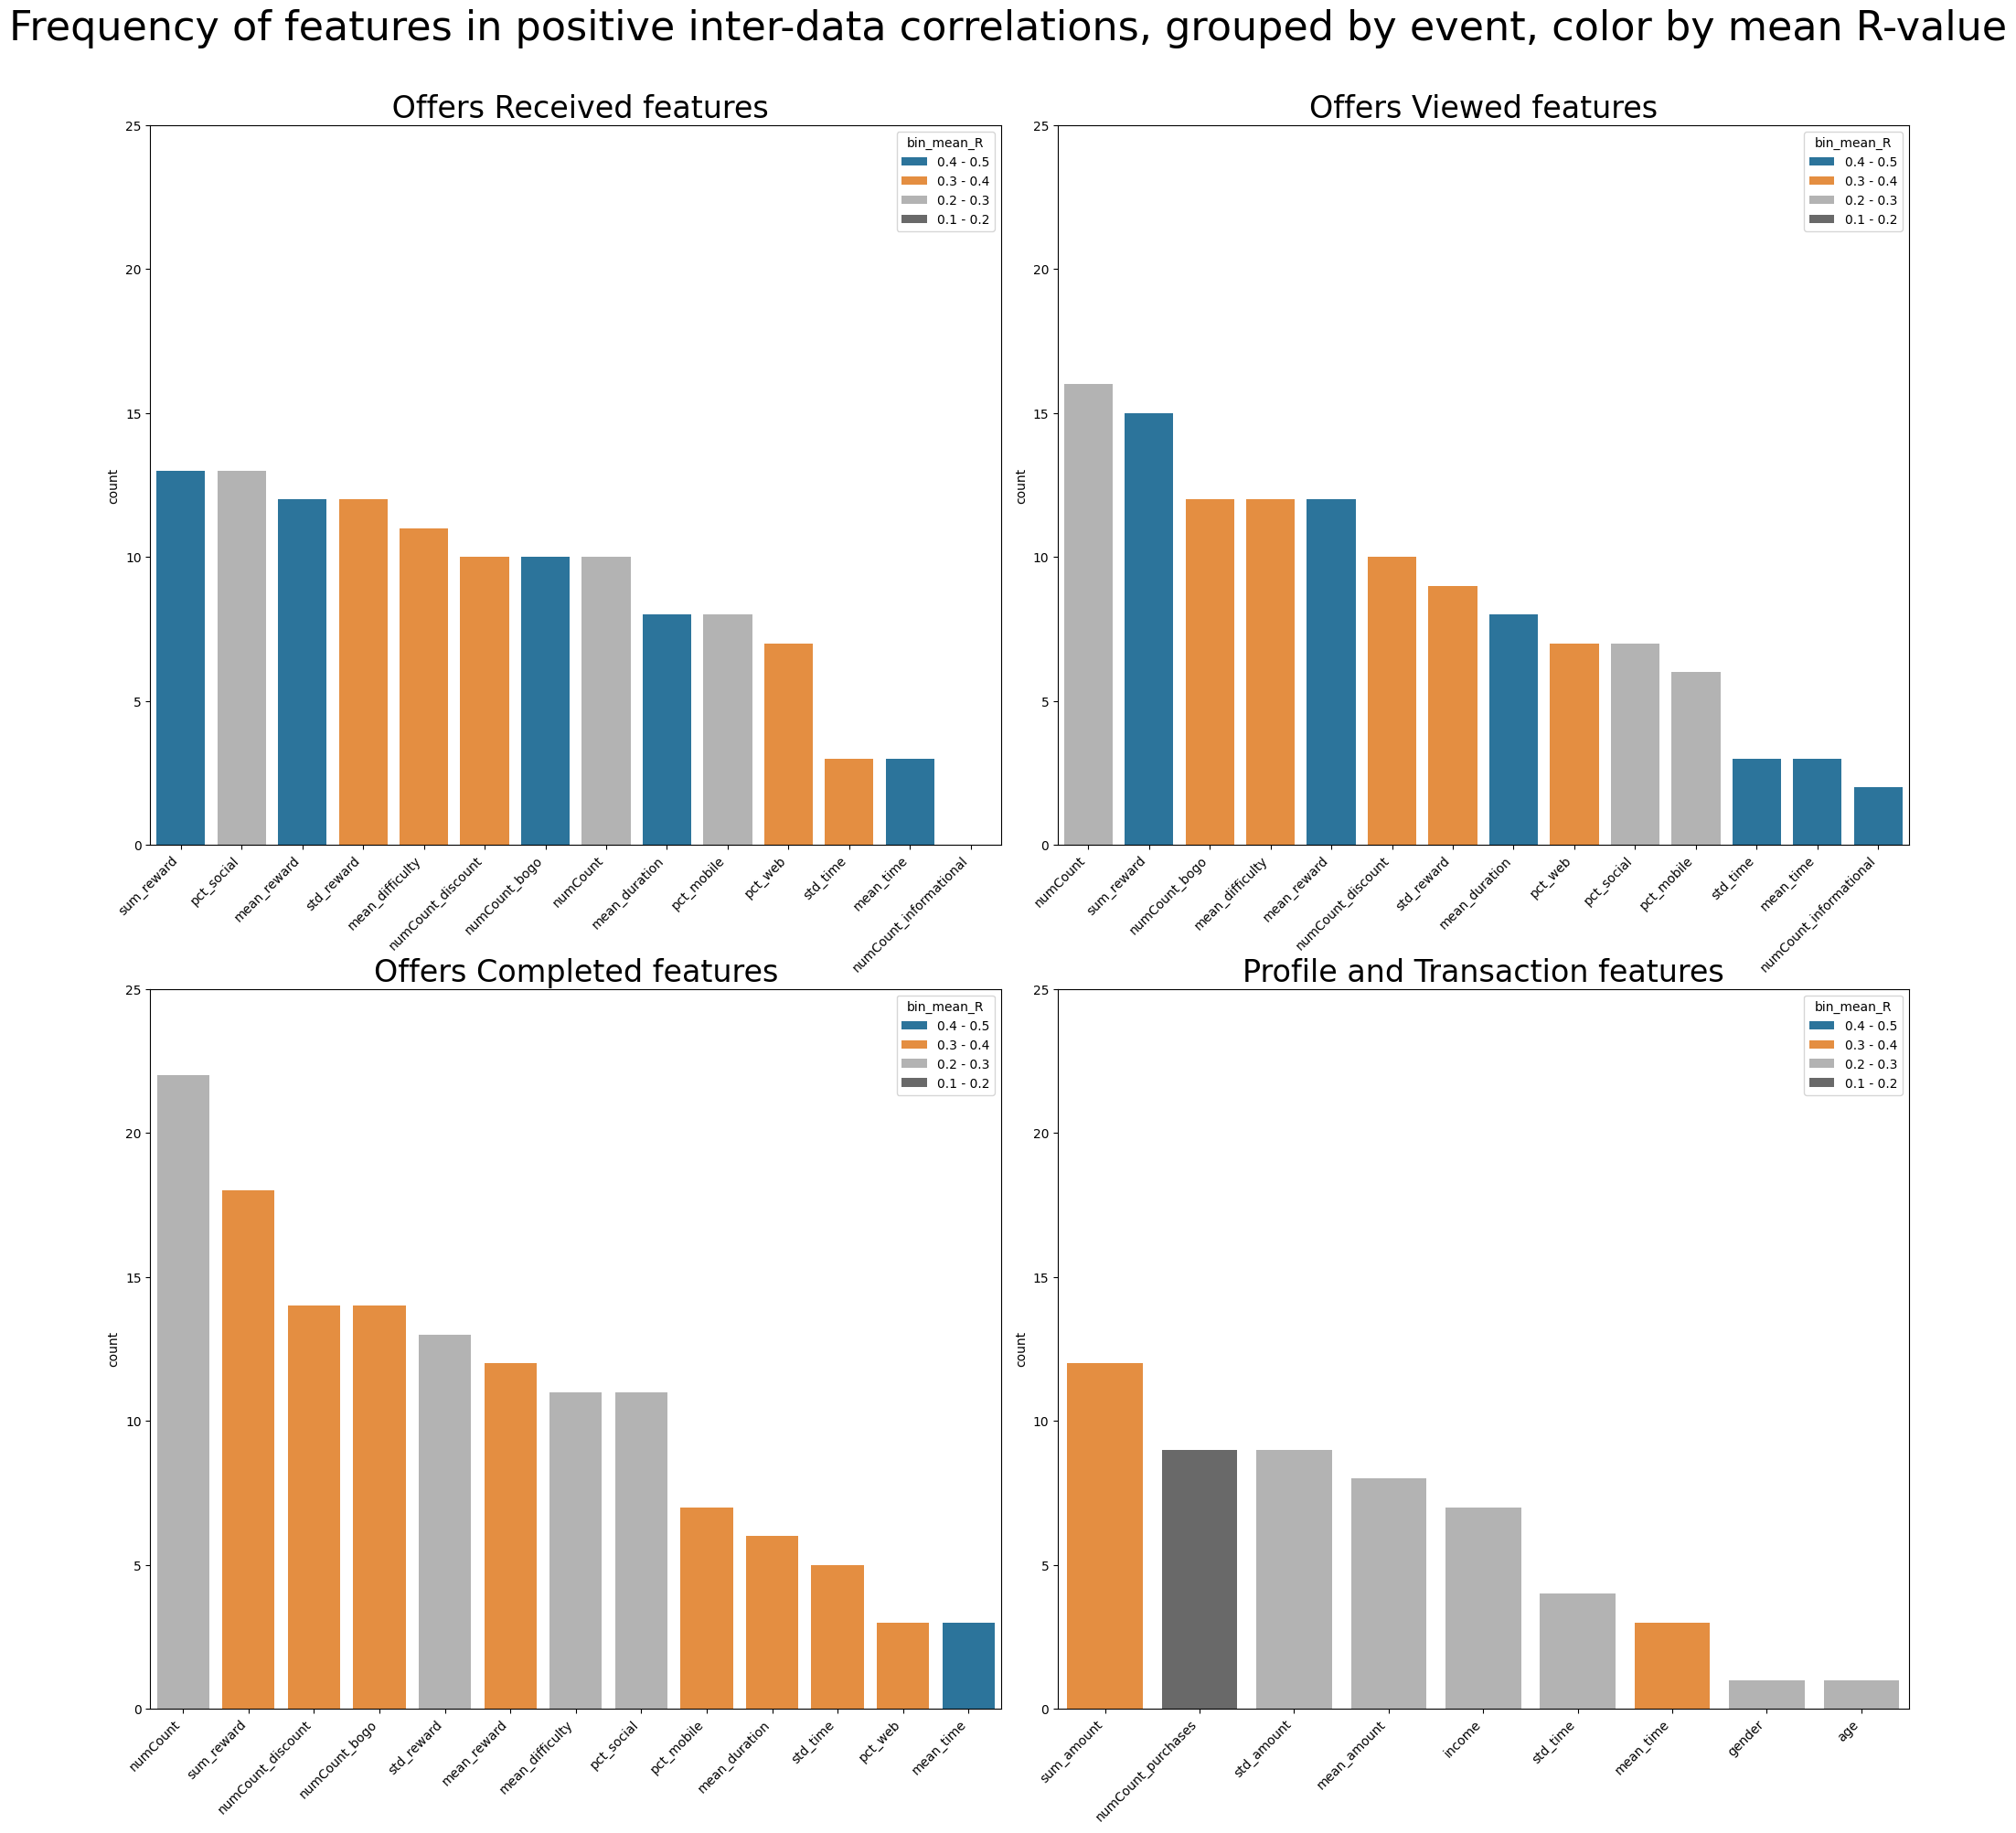

In [17]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.2)

plt.style.use('tableau-colorblind10')
hue_order = [ '0.4 - 0.5',  '0.3 - 0.4',  '0.2 - 0.3', '0.1 - 0.2']

sns.barplot(pos_corr.loc[pos_corr.event.str.contains('received')]\
    .sort_values(by='count', ascending=False), x='field', y='count', hue='bin_mean_R', hue_order = hue_order, alpha = 0.9, ax=ax1)
sns.barplot(pos_corr.loc[pos_corr.event.str.contains('viewed')]\
    .sort_values(by='count', ascending=False), x='field', y='count', hue='bin_mean_R', hue_order = hue_order, alpha = 0.9, ax=ax2)
sns.barplot(pos_corr.loc[pos_corr.event.str.contains('completed')]\
    .sort_values(by='count', ascending=False), x='field', y='count', hue='bin_mean_R', hue_order = hue_order, alpha = 0.9, ax=ax3)
sns.barplot(pos_corr.loc[pos_corr.event.str.contains('class')]\
    .sort_values(by='count', ascending=False), x='field', y='count', hue='bin_mean_R', hue_order = hue_order, alpha = 0.9, ax=ax4)


plt.setp(ax1.get_xticklabels(), rotation=45,ha ='right')
plt.setp(ax2.get_xticklabels(), rotation=45,ha ='right')
plt.setp(ax3.get_xticklabels(), rotation=45,ha ='right')
plt.setp(ax4.get_xticklabels(), rotation=45,ha ='right')
plt.setp(ax1.set_ylim(bottom=0, top=25))
plt.setp(ax2.set_ylim(bottom=0, top=25))
plt.setp(ax3.set_ylim(bottom=0, top=25))
plt.setp(ax4.set_ylim(bottom=0, top=25))

fig.suptitle('Frequency of features in positive inter-data correlations, grouped by event, color by mean R-value', fontsize=32, y=1.01)
ax1.title.set_text(' Offers Received features')
ax2.title.set_text('Offers Viewed features')
ax3.title.set_text('Offers Completed features')
ax4.title.set_text('Profile and Transaction features')

fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

_ = ax1.xaxis.set_label_text('')
_ = ax2.xaxis.set_label_text('')
_ = ax3.xaxis.set_label_text('')
_ = ax4.xaxis.set_label_text('')

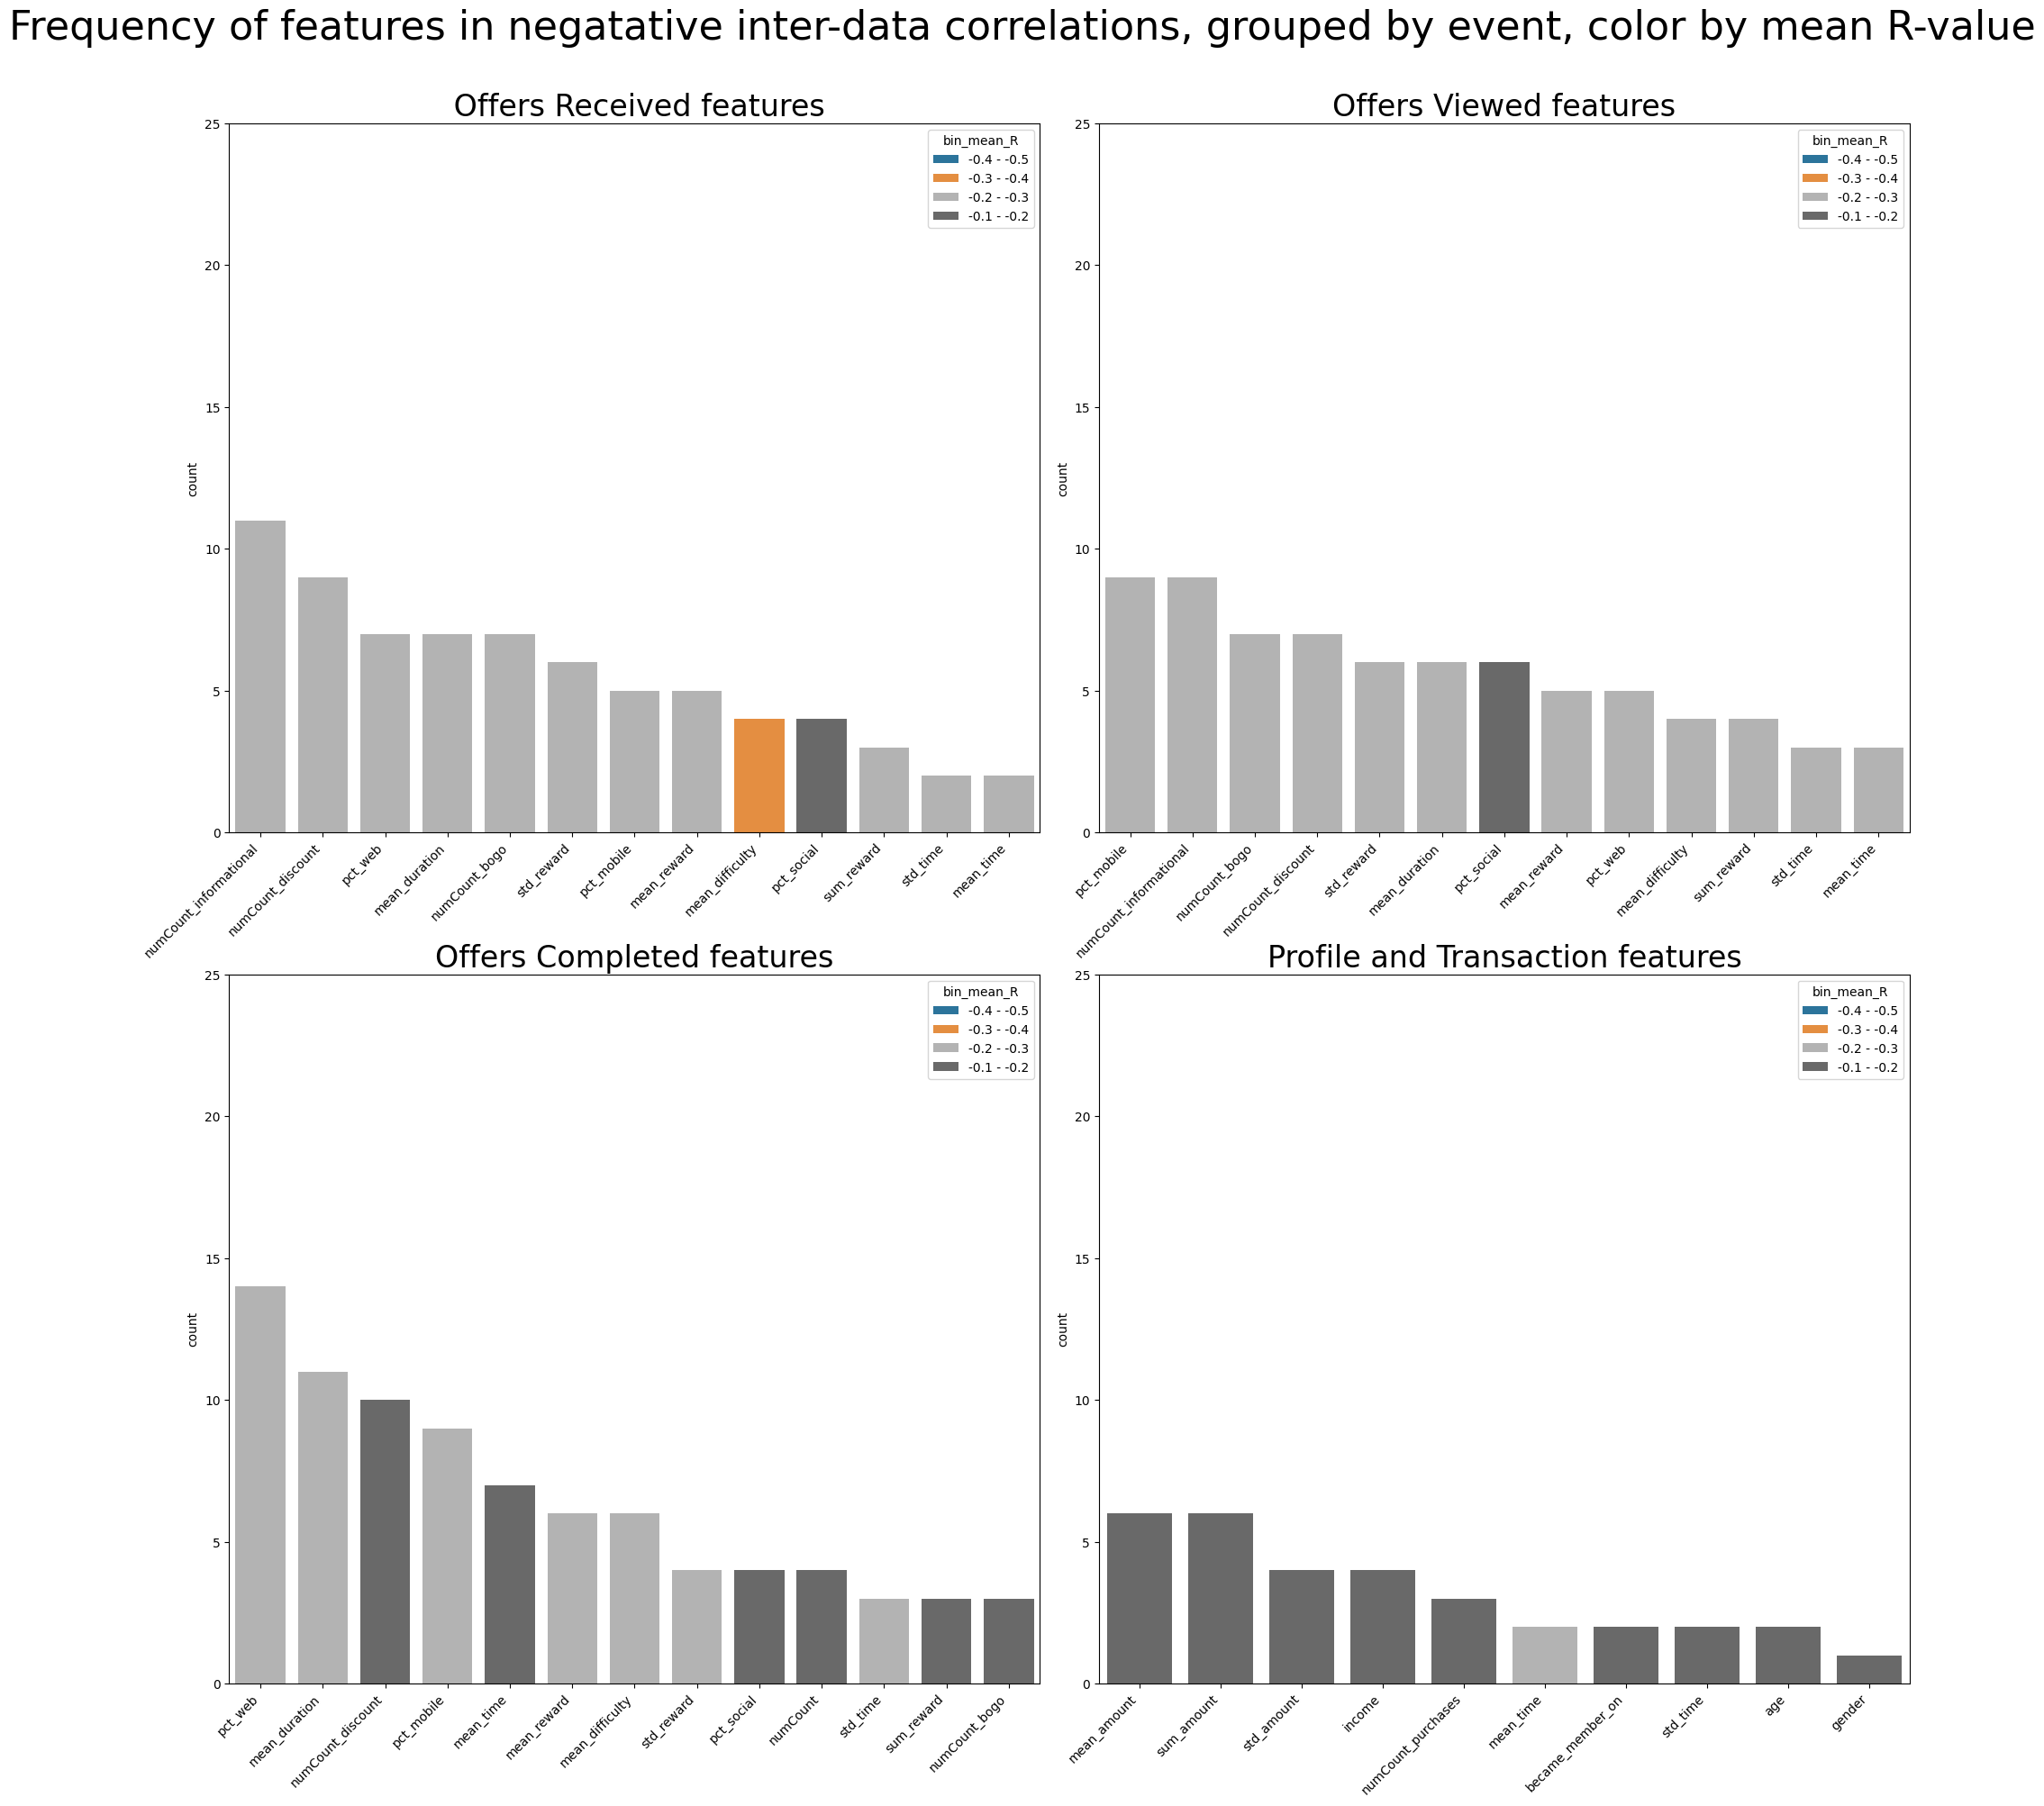

In [20]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2)

plt.style.use('tableau-colorblind10')
hue_order = [ '-0.4 - -0.5',  '-0.3 - -0.4',  '-0.2 - -0.3', '-0.1 - -0.2']

sns.barplot(neg_corr.loc[neg_corr.event.str.contains('received')]\
    .sort_values(by='count', ascending=False), x='field', y='count', hue='bin_mean_R', hue_order = hue_order, alpha = 0.9, ax=ax1)
sns.barplot(neg_corr.loc[neg_corr.event.str.contains('viewed')]\
    .sort_values(by='count', ascending=False), x='field', y='count', hue='bin_mean_R', hue_order = hue_order, alpha = 0.9, ax=ax2)
sns.barplot(neg_corr.loc[neg_corr.event.str.contains('completed')]\
    .sort_values(by='count', ascending=False), x='field', y='count', hue='bin_mean_R', hue_order = hue_order, alpha = 0.9, ax=ax3)
sns.barplot(neg_corr.loc[neg_corr.event.str.contains('class')]\
    .sort_values(by='count', ascending=False), x='field', y='count', hue='bin_mean_R', hue_order = hue_order, alpha = 0.9, ax=ax4)


plt.setp(ax1.get_xticklabels(), rotation=45,ha ='right')
plt.setp(ax2.get_xticklabels(), rotation=45,ha ='right')
plt.setp(ax3.get_xticklabels(), rotation=45,ha ='right')
plt.setp(ax4.get_xticklabels(), rotation=45,ha ='right')

fig.suptitle('Frequency of features in negatative inter-data correlations, grouped by event, color by mean R-value', fontsize=32, y=1.01)
ax1.title.set_text(' Offers Received features')
ax2.title.set_text('Offers Viewed features')
ax3.title.set_text('Offers Completed features')
ax4.title.set_text('Profile and Transaction features')
plt.setp(ax1.set_ylim(bottom=0, top=25))
plt.setp(ax2.set_ylim(bottom=0, top=25))
plt.setp(ax3.set_ylim(bottom=0, top=25))
plt.setp(ax4.set_ylim(bottom=0, top=25))

fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

_ = ax1.xaxis.set_label_text('')
_ = ax2.xaxis.set_label_text('')
_ = ax3.xaxis.set_label_text('')
_ = ax4.xaxis.set_label_text('')
# plt.style.use('ggplot')

# plt.hide()
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='event')

## Advanced Analytics

#### Create series of strongest_features and all_features outside of 'offer completed', 'event', and 'transaction'

In [46]:
cor1 = pos_corr2.loc[pos_corr2.event.str.contains('received') & (pos_corr2['mean'].between(0.4,0.5))].field
cor2 = pos_corr2.loc[pos_corr2.event.str.contains('viewed') & (pos_corr2['mean'].between(0.4,0.5))].field
cor3 = pos_corr2.loc[pos_corr2.event.str.contains('viewed') & (pos_corr2['count'] > 15)].field
cor4 = pos_corr2.loc[pos_corr2.event.str.contains('class') & (pos_corr2['mean'].between(0.4,0.5))].field
cor5 = neg_corr2.loc[neg_corr2.event.str.contains('received') & (neg_corr2['count'] > 10)].field
cor6 = neg_corr2.loc[neg_corr2.event.str.contains('viewed') & (neg_corr2['count'] > 8)].field
cor7 = neg_corr2.loc[neg_corr2.event.str.contains('class') & (neg_corr2['count'] > 6)].field
strongest_features = pd.concat([cor1, cor2, cor3, cor4, cor5, cor6, cor7]).tolist()
all_features = master_df.loc[:, ~master_df.columns.str.contains('OC|trans|event|person')].columns.tolist()

#### Compare linear and log regression 
- Linear regression seems to have problems with multiple inputs
  - it is saying that all columns are equally important, so something is wrong 
- Log regression seems to provide better response
- All features has slightly better precision than strongest features, but both results are comparable and give unique insights
  - For other model testing, we will use the all_features data 

In [77]:
#linear regression test 
master_df.event_OC=master_df.event_OC.astype('category')

y = master_df.event_OC.values #all data and correlations for classifier 

X = master_df[strongest_features]
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Feature Importance:")
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print(importance.head(10))

# print("\nTest Performance:")
# print(classification_report(y_test, model.predict(X_test)))


Feature Importance:
mean_duration_OR             0.014184
mean_reward_OR               0.014184
mean_time_OR                 0.014184
numCount_bogo_OR             0.014184
sum_reward_OR                0.014184
mean_duration_OV             0.014184
mean_reward_OV               0.014184
mean_time_OV                 0.014184
numCount_informational_OV    0.014184
std_time_OV                  0.014184
dtype: float64


### Log regression model

In [49]:
#running all features from master_df

master_df.event_OC=master_df.event_OC.astype('category')

#is label -- dependent variable, what are we trying to predict
y = master_df.event_OC.values #all data and correlations

X = master_df[strongest_features]
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Feature Importance:")
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print(importance.head(10))

print("\nTest Performance:")
print(classification_report(y_test, model.predict(X_test)))


Feature Importance:
numCount_OV                  0.524563
mean_duration_OV             0.145376
mean_reward_OR               0.136110
numCount_bogo_OR             0.106289
numCount_informational_OR    0.053052
sum_reward_OR                0.002780
std_time_OV                  0.000777
mean_time_OR                 0.000273
mean_time_OV                 0.000105
mean_duration_OR            -0.012933
dtype: float64

Test Performance:
              precision    recall  f1-score   support

           0       0.57      0.05      0.09       844
           1       0.76      0.99      0.86      2555

    accuracy                           0.75      3399
   macro avg       0.67      0.52      0.47      3399
weighted avg       0.71      0.75      0.67      3399



C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
#running all features from master_df

master_df.event_OC=master_df.event_OC.astype('category')

y = master_df.event_OC.values #all data and correlations

X = master_df[all_features]
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Feature Importance:")
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print(importance.head(10))

print("\nTest Performance:")
print(classification_report(y_test, model.predict(X_test)))


Feature Importance:
sum_reward_OV           0.015472
sum_reward_OR           0.009265
mean_duration_OV        0.008526
mean_difficulty_OV      0.008023
numCount_discount_OV    0.006932
numCount_OV             0.006746
numCount_discount_OR    0.005585
mean_duration_OR        0.005289
mean_difficulty_OR      0.005193
numCount_OR             0.003700
dtype: float64

Test Performance:
              precision    recall  f1-score   support

           0       0.61      0.35      0.45       844
           1       0.81      0.93      0.87      2555

    accuracy                           0.78      3399
   macro avg       0.71      0.64      0.66      3399
weighted avg       0.76      0.78      0.76      3399



C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Confusion matrix for Log model

In [76]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 295,  549],
       [ 186, 2369]])

##### See if precision changes when using different thresholds for log model
- default is 0.5
- optimal threshold for our model is somewhere around 0.3

In [56]:
y_probs = model.predict_proba(X_test)[:, 1]
for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    y_pred_t = (y_probs >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred_t))


Threshold = 0.2
              precision    recall  f1-score   support

           0       0.62      0.01      0.02       844
           1       0.75      1.00      0.86      2555

    accuracy                           0.75      3399
   macro avg       0.69      0.50      0.44      3399
weighted avg       0.72      0.75      0.65      3399


Threshold = 0.3
              precision    recall  f1-score   support

           0       0.67      0.06      0.11       844
           1       0.76      0.99      0.86      2555

    accuracy                           0.76      3399
   macro avg       0.71      0.53      0.49      3399
weighted avg       0.74      0.76      0.68      3399


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.63      0.22      0.33       844
           1       0.79      0.96      0.86      2555

    accuracy                           0.77      3399
   macro avg       0.71      0.59      0.60      3399
weighted avg       0.75

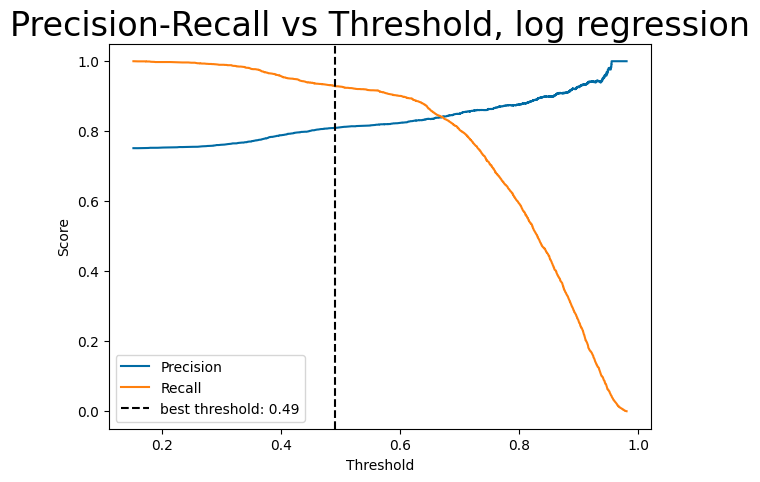

Best threshold: 0.49


In [68]:
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(7,5))
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.axvline(x=0.49, linestyle = '--', label = 'best threshold: 0.49', color='black')
plt.title('Precision-Recall vs Threshold, log regression')
plt.legend()
plt.show()
f1 = 2*(prec*rec)/(prec+rec)
best_t = thresh[np.argmax(f1)]
print(f"Best threshold: {best_t:.2f}")

### Random Forest Classifier
- comparing models to see if there are other important features
- Confusion matrix shows that model does a decent job identifying true positive and true negatives
- AUC score of 0.85 shows that it is a valid model

In [28]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    max_depth=10
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_probs_rf = rf.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_probs_rf))
print(classification_report(y_test, y_pred_rf))

AUC: 0.8576715111156454
              precision    recall  f1-score   support

           0       0.55      0.70      0.62       844
           1       0.89      0.81      0.85      2555

    accuracy                           0.78      3399
   macro avg       0.72      0.76      0.73      3399
weighted avg       0.81      0.78      0.79      3399



#### Confusion matrix for RFC

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
conf_matrix

array([[ 593,  251],
       [ 484, 2071]])

#### Most important features from RFC

In [30]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(10))


became_member_on        0.222429
income                  0.170178
age                     0.107700
gender                  0.079101
numCount_discount_OV    0.031043
mean_duration_OV        0.030007
std_time_OV             0.023186
pct_social_OV           0.022643
std_reward_OV           0.022181
numCount_OV             0.020708
dtype: float64


In [31]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print(scores.mean(), scores.std())

0.8669672460129654 0.007563511111966992


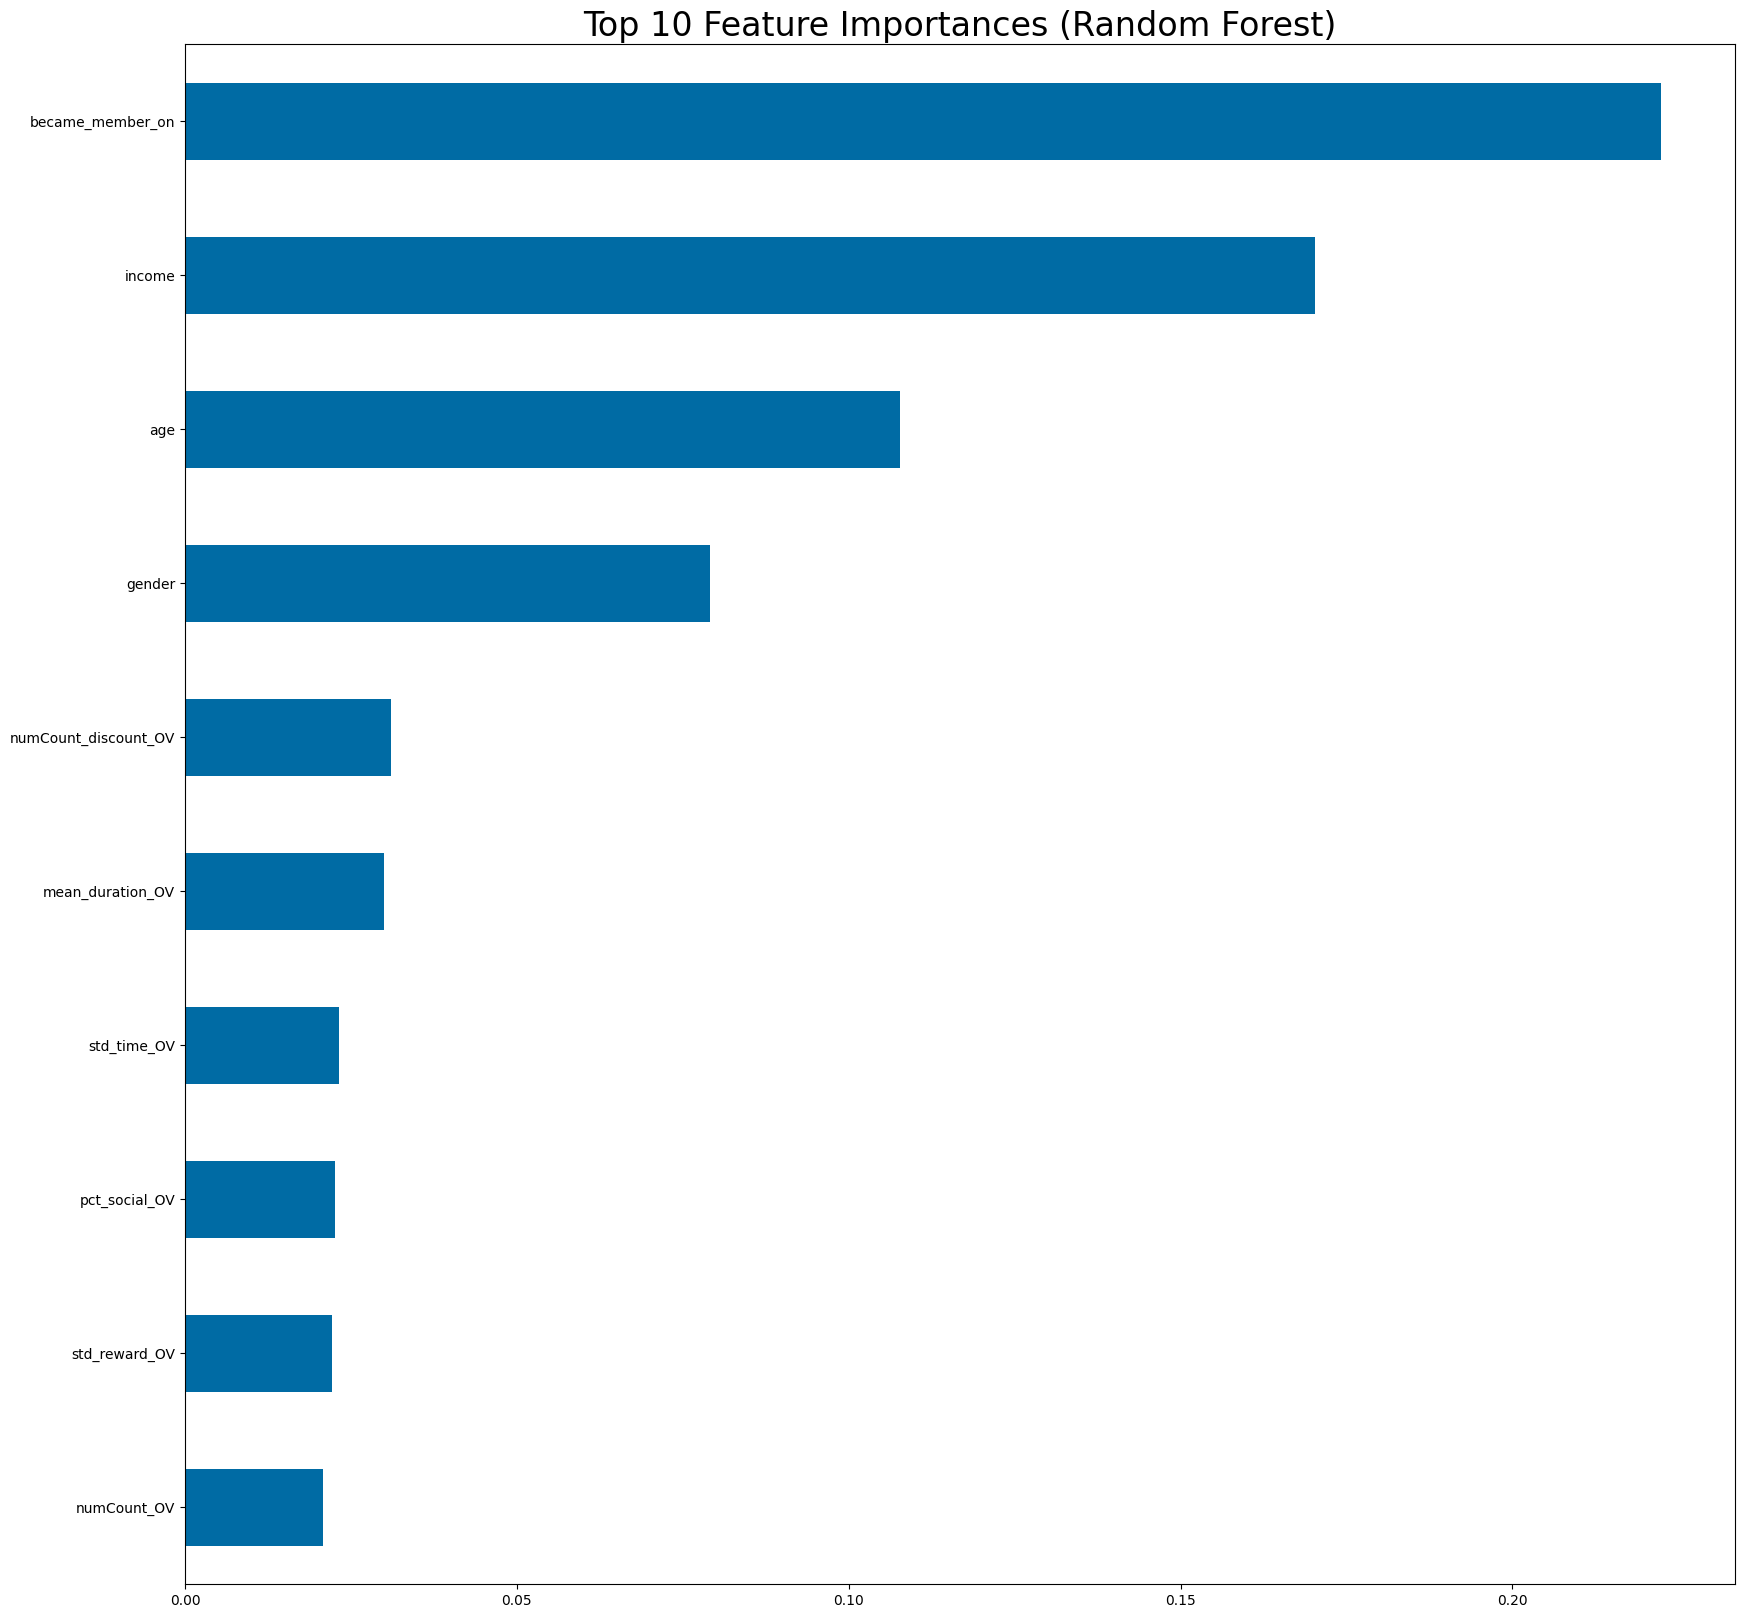

In [32]:
importances.sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()


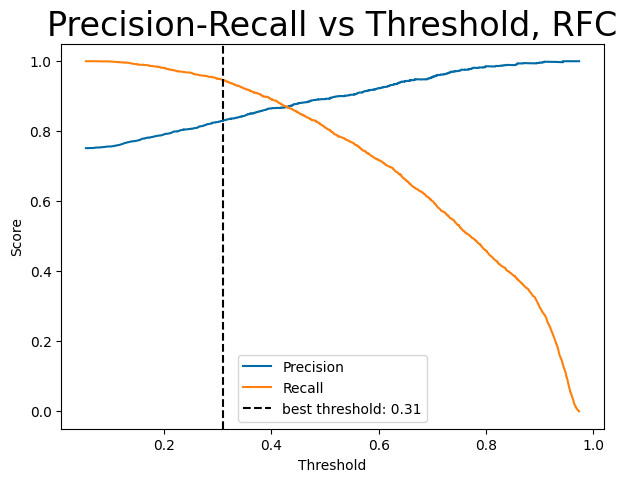

Best threshold: 0.31


In [66]:
prec, rec, thresh = precision_recall_curve(y_test, y_probs_rf)

plt.figure(figsize=(7,5))
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.axvline(x=0.31, linestyle = '--', label = 'best threshold: 0.31', color='black')
plt.title('Precision-Recall vs Threshold, RFC')
plt.legend()
plt.show()
f1 = 2*(prec*rec)/(prec+rec)
best_t = thresh[np.argmax(f1)]
print(f"Best threshold: {best_t:.2f}")


### XGBoost model 
- comparing models to see if there are other important features
- Confusion matrix shows that model does a decent job identifying true positive and true negatives
- AUC score of 0.85 shows that it is a valid model
- XGBoost and RFC models have similar performances

In [34]:
# Clean up column names for XGBoost
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

# Replace bad characters
X_train_xgb.columns = (
    X_train_xgb.columns
    .str.replace(r"[\[\]',<> ]+", "_", regex=True)
    .str.strip("_")
)

X_test_xgb.columns = X_train_xgb.columns  # ensure identical columns


In [35]:
# Handle class imbalance
scale_pos = (len(y_train) - sum(y_train)) / sum(y_train)

xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train_xgb, y_train)

y_pred_xgb = xgb.predict(X_test_xgb)
y_probs_xgb = xgb.predict_proba(X_test_xgb)[:, 1]

print("AUC:", roc_auc_score(y_test, y_probs_xgb))
print(classification_report(y_test, y_pred_xgb))


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:08:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.8498478960499347
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       844
           1       0.89      0.81      0.85      2555

    accuracy                           0.78      3399
   macro avg       0.72      0.75      0.73      3399
weighted avg       0.81      0.78      0.79      3399



#### Confusion matrix for XGB

In [72]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
conf_matrix

array([[ 586,  258],
       [ 479, 2076]])

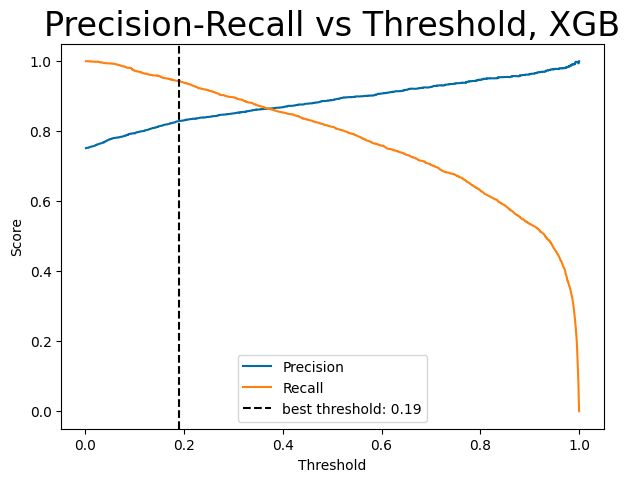

Best threshold: 0.19


In [71]:
prec, rec, thresh = precision_recall_curve(y_test, y_probs_xgb)

plt.figure(figsize=(7,5))
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.axvline(x=0.19, linestyle = '--', label = 'best threshold: 0.19', color='black')
plt.title('Precision-Recall vs Threshold, XGB')
plt.legend()
plt.show()
f1 = 2*(prec*rec)/(prec+rec)
best_t = thresh[np.argmax(f1)]
print(f"Best threshold: {best_t:.2f}")


In [36]:
xgb_tuned = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_tuned.fit(X_train_xgb, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [37]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions
y_pred_tuned = xgb_tuned.predict(X_test_xgb)
y_probs_tuned = xgb_tuned.predict_proba(X_test_xgb)[:, 1]

# Evaluate
print("AUC:", roc_auc_score(y_test, y_probs_tuned))
print(classification_report(y_test, y_pred_tuned))


AUC: 0.8545863050797154
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       844
           1       0.89      0.82      0.85      2555

    accuracy                           0.79      3399
   macro avg       0.73      0.76      0.74      3399
weighted avg       0.81      0.79      0.80      3399

